In [71]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler,ConcatDataset,Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import torchvision
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets,models
import torchvision.datasets.utils as dataset_utils

###Preparing Coloured MNIST

In [64]:
def color_grayscale_arr(arr):
  #assert arr.ndim == 2
  dtype = arr.dtype
  _,h, w = arr.shape
  #arr = np.reshape(arr, [1,h, w])
  arr = np.concatenate([arr,
                          np.random.rand(2,h, w)], axis=0)

  return arr


class ColoredMNIST(datasets.VisionDataset):

  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):

    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    transform_train1 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True,transform = transform_train1)

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)

      colored_arr = color_grayscale_arr(im_array)

      if idx < 50000:
        train1_set.append((torch.from_numpy(colored_arr), label))
      else:
        test_set.append((torch.from_numpy(colored_arr), label))

    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

#Q1

##Load MNIST


In [110]:
transform_train1 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
transform_test1 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [111]:
class MNISTDataset(Dataset):
    def __init__(self, train=True,transform=None):
        if train:
            self.data = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transform)
        else:
            self.data = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.stack([x.squeeze(1),x.squeeze(1),x.squeeze(1)],dim=1)
        x = x.squeeze(0)
        return x, y

In [112]:
traindata1 = MNISTDataset(True,transform_train1)
testdata1 = MNISTDataset(False,transform_test1)

In [113]:
mnist_by_class = [[] for _ in range(10)]
for i in range(len(traindata1)):
    image, label = traindata1[i]
    mnist_by_class[label].append(image)

class_count = [len(mnist_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in traindata1]

sampler = WeightedRandomSampler(weights, num_samples=10000, replacement=False)
    
train_dataloader1 = DataLoader(traindata1, batch_size=64, sampler=sampler)

In [114]:
mnist_by_class = [[] for _ in range(10)]
for i in range(len(testdata1)):
    image, label = testdata1[i]
    mnist_by_class[label].append(image)

class_count = [len(mnist_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in testdata1]

sampler = WeightedRandomSampler(weights, num_samples=5000, replacement=False)
    
test_dataloader1 = DataLoader(testdata1, batch_size=16, sampler=sampler)

##Load Coloured MNIST

In [65]:
transform_train2 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

In [66]:
#Create a folder name 'ColoredMNIST' in the data folder first
traindata2= ColoredMNIST(root='./data', env='train1')
testdata2= ColoredMNIST(root='./data', env='test')

Preparing Colored MNIST
Converting image 0/60000
Converting image 10000/60000
Converting image 20000/60000
Converting image 30000/60000
Converting image 40000/60000
Converting image 50000/60000
Preparing Colored MNIST
Converting image 0/60000
Converting image 10000/60000
Converting image 20000/60000
Converting image 30000/60000
Converting image 40000/60000
Converting image 50000/60000


In [67]:
mnist_by_class = [[] for _ in range(10)]
for i in range(len(traindata2)):
    image, label = traindata2[i]
    mnist_by_class[label].append(image)

class_count = [len(mnist_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in traindata2]

sampler = WeightedRandomSampler(weights, num_samples=10000, replacement=False)
    
train_dataloader2 = DataLoader(traindata2, batch_size=64, sampler=sampler)

In [68]:
mnist_by_class = [[] for _ in range(10)]
for i in range(len(testdata2)):
    image, label = testdata2[i]
    mnist_by_class[label].append(image)

class_count = [len(mnist_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in testdata2]

sampler = WeightedRandomSampler(weights, num_samples=5000, replacement=False)
    
test_dataloader2 = DataLoader(testdata2, batch_size=16, sampler=sampler)

##Load SVHN

In [96]:
transform_train3 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614)),
])
transform_test3 = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614)),
])

In [97]:
traindata3= datasets.SVHN('./data', split='train', download=True,
                       transform= transform_train3)
testdata3= datasets.SVHN('./data', split='test', download=True,transform= transform_test3)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [98]:
svhn_by_class = [[] for _ in range(10)]
for i in range(len(traindata3)):
    image, label = traindata3[i]
    svhn_by_class[label].append(image)

class_count = [len(svhn_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in traindata3]

sampler = WeightedRandomSampler(weights, num_samples=10000, replacement=False)
    
train_dataloader3 = DataLoader(traindata3, batch_size=64, sampler=sampler)

In [99]:
svhn_by_class = [[] for _ in range(10)]
for i in range(len(testdata3)):
    image, label = testdata3[i]
    svhn_by_class[label].append(image)

class_count = [len(svhn_by_class[i]) for i in range(10)]
weights = [1.0 / class_count[label] for image, label in testdata3]

sampler = WeightedRandomSampler(weights, num_samples=5000, replacement=False)
    
test_dataloader3 = DataLoader(testdata3, batch_size=16, sampler=sampler)

##Training

In [22]:
class Resnet(torch.nn.Module):
    def __init__(self, num_classes,grayscale=False):
        super(Resnet, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Linear(512,num_classes)

    def forward(self, x):
        outputs = self.backbone(x)
        return outputs

In [86]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    criterion = nn.CrossEntropyLoss()
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda().float(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
    return running_loss/len(train_loader)

In [87]:
def server_aggregate(global_model, client_models):
      global_dict = global_model.state_dict()
      for k in global_dict.keys():
          global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model.load_state_dict(global_dict)
      for model in client_models:
          model.load_state_dict(global_model.state_dict())

In [88]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    total = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda().float(), target.cuda()
            output = global_model(data)
            test_loss += criterion(output, target).item() 
            _, preds = torch.max(output, 1)
            total += target.size(0)
            correct += (preds == target).sum().item()

    test_loss /= total
    acc = correct / total

    return test_loss, acc

In [89]:
global_model =  Resnet(10).cuda()
model1 = Resnet(10).cuda()
model2 = Resnet(10).cuda()
model3 = Resnet(10).cuda()
client_models = [model1,model2,model3]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

opt = [optim.SGD(model.parameters(), lr=0.01) for model in client_models]

In [90]:
num_clients = 3
num_selected = 3
num_rounds = 15
epochs = 5
batch_size = 64

In [91]:
trainloader = [train_dataloader1,train_dataloader2,train_dataloader3]
losses_train1,losses_train2,losses_train3,losses_global = [],[],[],[]
losses_test1,losses_test2,losses_test3 = [],[],[]
acc_train = []
acc_test1,acc_test2,acc_test3 = [],[],[]
# Runnining FL

for r in range(num_rounds):
    # client update
    loss_global = 0
    for i in tqdm(range(num_selected)):
        loss_client = client_update(client_models[i], opt[i], trainloader[i], epoch=epochs)
        if i == 0:
          losses_train1.append(loss_client)
        elif i==1:
          losses_train2.append(loss_client)
        elif i==2:
          losses_train3.append(loss_client)
        loss_global += loss_client


    losses_global.append(loss_global)
    server_aggregate(global_model, client_models)
    
    test_loss, acc = test(global_model, test_dataloader1)
    losses_test1.append(test_loss)
    acc_test1.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (losses_train1[r], test_loss, acc))
    test_loss, acc = test(global_model, test_dataloader2)
    losses_test2.append(test_loss)
    acc_test2.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (losses_train2[r], test_loss, acc))
    test_loss, acc = test(global_model, test_dataloader3)
    losses_test3.append(test_loss)
    acc_test3.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (losses_train3[r], test_loss, acc))

100%|██████████| 3/3 [01:20<00:00, 26.87s/it]


0-th round
average train loss 0.0946 | test loss 0.464 | test acc: 0.853
0-th round
average train loss 0.0598 | test loss 0.442 | test acc: 0.861
0-th round
average train loss 0.615 | test loss 1.83 | test acc: 0.429


100%|██████████| 3/3 [01:21<00:00, 27.12s/it]


1-th round
average train loss 0.0802 | test loss 0.308 | test acc: 0.909
1-th round
average train loss 0.0411 | test loss 0.275 | test acc: 0.917
1-th round
average train loss 0.518 | test loss 1.33 | test acc: 0.612


100%|██████████| 3/3 [01:19<00:00, 26.52s/it]


2-th round
average train loss 0.0604 | test loss 0.205 | test acc: 0.937
2-th round
average train loss 0.0367 | test loss 0.193 | test acc: 0.943
2-th round
average train loss 0.475 | test loss 1.14 | test acc: 0.672


100%|██████████| 3/3 [01:18<00:00, 26.33s/it]


3-th round
average train loss 0.0532 | test loss 0.192 | test acc: 0.943
3-th round
average train loss 0.0257 | test loss 0.169 | test acc: 0.952
3-th round
average train loss 0.422 | test loss 0.97 | test acc: 0.727


100%|██████████| 3/3 [01:20<00:00, 26.75s/it]


4-th round
average train loss 0.0522 | test loss 0.175 | test acc: 0.946
4-th round
average train loss 0.0203 | test loss 0.166 | test acc: 0.950
4-th round
average train loss 0.393 | test loss 0.926 | test acc: 0.745


100%|██████████| 3/3 [01:19<00:00, 26.62s/it]


5-th round
average train loss 0.0389 | test loss 0.141 | test acc: 0.958
5-th round
average train loss 0.0191 | test loss 0.13 | test acc: 0.962
5-th round
average train loss 0.365 | test loss 0.875 | test acc: 0.758


100%|██████████| 3/3 [01:19<00:00, 26.63s/it]


6-th round
average train loss 0.0368 | test loss 0.146 | test acc: 0.961
6-th round
average train loss 0.0139 | test loss 0.117 | test acc: 0.966
6-th round
average train loss 0.354 | test loss 0.805 | test acc: 0.779


100%|██████████| 3/3 [01:18<00:00, 26.05s/it]


7-th round
average train loss 0.0328 | test loss 0.148 | test acc: 0.956
7-th round
average train loss 0.0145 | test loss 0.128 | test acc: 0.961
7-th round
average train loss 0.328 | test loss 0.764 | test acc: 0.788


100%|██████████| 3/3 [01:17<00:00, 25.85s/it]


8-th round
average train loss 0.0327 | test loss 0.141 | test acc: 0.960
8-th round
average train loss 0.0123 | test loss 0.0912 | test acc: 0.974
8-th round
average train loss 0.305 | test loss 0.737 | test acc: 0.799


100%|██████████| 3/3 [01:17<00:00, 25.88s/it]


9-th round
average train loss 0.0276 | test loss 0.131 | test acc: 0.962
9-th round
average train loss 0.011 | test loss 0.0916 | test acc: 0.977
9-th round
average train loss 0.298 | test loss 0.691 | test acc: 0.813


100%|██████████| 3/3 [01:19<00:00, 26.47s/it]


10-th round
average train loss 0.0253 | test loss 0.117 | test acc: 0.967
10-th round
average train loss 0.0106 | test loss 0.0861 | test acc: 0.977
10-th round
average train loss 0.285 | test loss 0.673 | test acc: 0.822


100%|██████████| 3/3 [01:18<00:00, 26.05s/it]


11-th round
average train loss 0.0236 | test loss 0.0922 | test acc: 0.974
11-th round
average train loss 0.0127 | test loss 0.0815 | test acc: 0.978
11-th round
average train loss 0.283 | test loss 0.703 | test acc: 0.824


100%|██████████| 3/3 [01:19<00:00, 26.42s/it]


12-th round
average train loss 0.0304 | test loss 0.097 | test acc: 0.972
12-th round
average train loss 0.00682 | test loss 0.0794 | test acc: 0.981
12-th round
average train loss 0.252 | test loss 0.714 | test acc: 0.821


100%|██████████| 3/3 [01:19<00:00, 26.43s/it]


13-th round
average train loss 0.0252 | test loss 0.0976 | test acc: 0.972
13-th round
average train loss 0.00497 | test loss 0.0705 | test acc: 0.982
13-th round
average train loss 0.254 | test loss 0.643 | test acc: 0.833


100%|██████████| 3/3 [01:19<00:00, 26.59s/it]


14-th round
average train loss 0.0252 | test loss 0.0929 | test acc: 0.975
14-th round
average train loss 0.0072 | test loss 0.0762 | test acc: 0.980
14-th round
average train loss 0.251 | test loss 0.625 | test acc: 0.837


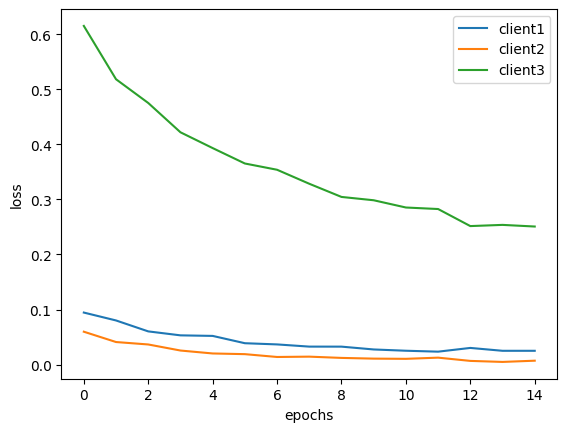

In [93]:
plt.plot(range(len(losses_train1)),losses_train1,label='client1')
plt.plot(range(len(losses_train2)),losses_train2,label='client2')
plt.plot(range(len(losses_train3)),losses_train3,label='client3')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

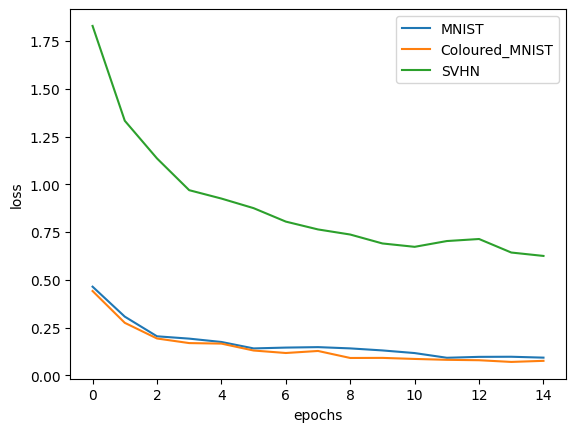

In [94]:
plt.plot(range(len(losses_test1)),losses_test1,label='MNIST')
plt.plot(range(len(losses_test2)),losses_test2,label='Coloured_MNIST')
plt.plot(range(len(losses_test3)),losses_test3,label='SVHN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

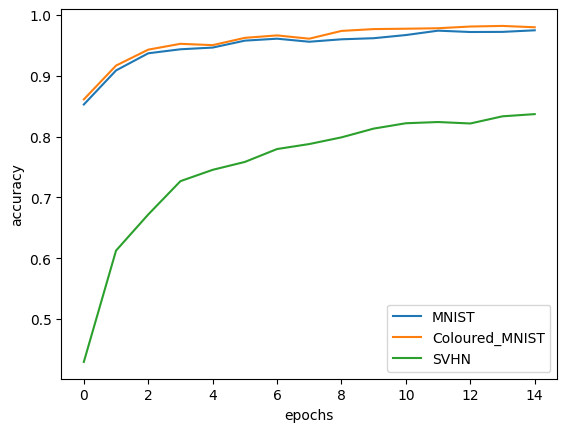

In [95]:
plt.plot(range(len(acc_test1)),acc_test1,label='MNIST')
plt.plot(range(len(acc_test2)),acc_test2,label='Coloured_MNIST')
plt.plot(range(len(acc_test3)),acc_test3,label='SVHN')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

##Class-wise accuracy

In [96]:
def class_wise_acc(model_ft,dataloader,overall=False):
  nb_classes = 10
  total = 0
  correct = 0
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(tqdm(dataloader)):
          inputs = inputs.float().cuda()
          classes = classes.cuda()
          outputs = model_ft(inputs)
          _, preds = torch.max(outputs, 1)
          total += classes.size(0)
          correct += (preds == classes).sum().item()
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  if not overall:
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
  else:
    #accuracy = torch.tensor(torch.trace(torch.tensor(confusion_matrix))) / torch.sum(torch.tensor(confusion_matrix))
    print(correct*100/total)
    #print((accuracy.item())*100)
    print(confusion_matrix)
    return correct*100/total
  print(' ')

###Client-side

In [97]:
print('Class-wise accuracy of client 1')
class_wise_acc(model1,test_dataloader1,False)
print('Class-wise accuracy of client 2')
class_wise_acc(model2,test_dataloader2,False)
print('Class-wise accuracy of client 3')
class_wise_acc(model3,test_dataloader3,False)

Class-wise accuracy of client 1


100%|██████████| 313/313 [00:04<00:00, 71.38it/s]


tensor([0.9818, 0.9845, 0.9673, 0.9621, 0.9793, 0.9636, 0.9708, 0.9663, 0.9879,
        0.9689])
 
Class-wise accuracy of client 2


100%|██████████| 313/313 [00:02<00:00, 113.74it/s]


tensor([0.9896, 0.9720, 0.9881, 0.9857, 0.9739, 0.9775, 0.9959, 0.9778, 0.9801,
        0.9741])
 
Class-wise accuracy of client 3


100%|██████████| 313/313 [00:04<00:00, 70.49it/s]

tensor([0.0020, 0.9779, 0.0100, 0.1708, 0.1548, 0.0096, 0.0085, 0.0373, 0.2786,
        0.0144])
 


###Server-side

In [98]:
print('class-wise accuracy of server for MNIST')
class_wise_acc(global_model,test_dataloader1,False)
print('class-wise accuracy of server for Coloured MNIST')
class_wise_acc(global_model,test_dataloader2,False)
print('class-wise accuracy of server for SVHN')
class_wise_acc(global_model,test_dataloader3,False)

class-wise accuracy of server for MNIST


100%|██████████| 313/313 [00:04<00:00, 76.73it/s]


tensor([0.9938, 0.9885, 0.9572, 0.9759, 0.9798, 0.9574, 0.9801, 0.9601, 0.9796,
        0.9619])
 
class-wise accuracy of server for Coloured MNIST


100%|██████████| 313/313 [00:02<00:00, 117.27it/s]


tensor([0.9864, 0.9806, 0.9793, 0.9861, 0.9839, 0.9690, 0.9886, 0.9742, 0.9817,
        0.9937])
 
class-wise accuracy of server for SVHN


100%|██████████| 313/313 [00:04<00:00, 65.78it/s]

tensor([0.9223, 0.8860, 0.8542, 0.7056, 0.8553, 0.8696, 0.8198, 0.8804, 0.8455,
        0.7982])
 


##Overall Accuracy & Confusion Matrix

In [99]:
print('Overall accuracy and confusion matrix of client 1')
class_wise_acc(model1,test_dataloader1,True)
print('Overall accuracy and confusion matrix of client 2')
class_wise_acc(model2,test_dataloader2,True)
print('Overall accuracy and confusion matrix of client 3')
class_wise_acc(model3,test_dataloader3,True)
print('Overall accuracy and confusion matrix of server for MNIST')
acc1 = class_wise_acc(global_model,test_dataloader1,True)
print('Overall accuracy and confusion matrix of server for Coloured MNIST')
acc2 = class_wise_acc(global_model,test_dataloader2,True)
print('Overall accuracy and confusion matrix of server for SVHN')
acc3 = class_wise_acc(global_model,test_dataloader3,True)
print('Overall accuracy and confusion matrix of server for all')
print((acc1+acc2+acc3)/3)

Overall accuracy and confusion matrix of client 1


100%|██████████| 313/313 [00:04<00:00, 74.71it/s]


97.42
tensor([[494.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.],
        [  0., 526.,   0.,   2.,   2.,   0.,   0.,   2.,   0.,   0.],
        [  3.,   2., 505.,   1.,   1.,   2.,   4.,   1.,   0.,   0.],
        [  1.,   0.,   0., 500.,   0.,   6.,   0.,   0.,   2.,   1.],
        [  1.,   3.,   1.,   0., 502.,   0.,   2.,   1.,   5.,   9.],
        [  0.,   2.,   4.,   5.,   1., 454.,   0.,   1.,   0.,   0.],
        [  5.,   1.,   1.,   3.,   0.,   2., 483.,   1.,   0.,   0.],
        [  2.,   8.,   6.,   1.,   0.,   4.,   0., 465.,   0.,   1.],
        [  1.,   0.,   2.,   4.,   0.,   3.,   1.,   1., 467.,   1.],
        [  0.,   0.,   3.,   2.,   4.,   1.,   0.,   2.,   2., 475.]])
Overall accuracy and confusion matrix of client 2


100%|██████████| 313/313 [00:02<00:00, 114.45it/s]


98.08
tensor([[466.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   1.,   0.],
        [  4., 482.,   0.,   0.,   1.,   2.,   1.,   2.,   0.,   0.],
        [  0.,   1., 502.,   3.,   0.,   1.,   0.,   1.,   1.,   0.],
        [  1.,   0.,   2., 497.,   0.,   3.,   0.,   1.,   2.,   2.],
        [  1.,   3.,   1.,   0., 515.,   0.,   1.,   0.,   1.,   5.],
        [  1.,   0.,   1.,   2.,   0., 472.,   5.,   2.,   0.,   2.],
        [  0.,   0.,   0.,   0.,   0.,   3., 514.,   0.,   0.,   0.],
        [  1.,   4.,   3.,   0.,   0.,   1.,   0., 495.,   1.,   2.],
        [  0.,   0.,   0.,   2.,   0.,   2.,   2.,   0., 492.,   5.],
        [  1.,   1.,   1.,   1.,   6.,   0.,   0.,   1.,   2., 469.]])
Overall accuracy and confusion matrix of client 3


100%|██████████| 313/313 [00:04<00:00, 73.77it/s]


18.42
tensor([[  2., 453.,   0.,  37.,   2.,   0.,   0.,   0.,   6.,   0.],
        [  0., 557.,   0.,   1.,   2.,   0.,   0.,   2.,   0.,   0.],
        [  0., 280.,   5., 137.,  56.,   0.,   0.,   0.,  27.,   0.],
        [  0., 364.,   0.,  95.,  28.,   0.,   0.,   0.,  46.,   0.],
        [  0., 330.,   1.,  53.,  85.,   0.,   0.,   0.,   8.,   0.],
        [  0., 221.,   0., 213.,  40.,   5.,   1.,   0.,  17.,   0.],
        [  0., 312.,   0.,  94.,  50.,   0.,   5.,   1.,  28.,   0.],
        [  0., 426.,   0.,  58.,   2.,   0.,   0.,  16.,   4.,   0.],
        [  0., 278.,   0.,  33.,  24.,   0.,   0.,   0., 144.,   0.],
        [  0., 310.,   4.,  55.,  29.,   1.,   0.,   2.,  43.,   7.]])
Overall accuracy and confusion matrix of server for MNIST


100%|██████████| 313/313 [00:04<00:00, 71.24it/s]


96.88
tensor([[511.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.],
        [  2., 483.,   0.,   3.,   2.,   0.,   5.,   1.,   0.,   0.],
        [  0.,   2., 471.,   4.,   4.,   3.,   7.,   5.,   2.,   0.],
        [  1.,   0.,   6., 466.,   0.,   5.,   0.,   0.,   3.,   2.],
        [  1.,   2.,   1.,   0., 499.,   0.,   0.,   0.,   1.,   7.],
        [  1.,   0.,   8.,   4.,   0., 464.,   5.,   2.,   0.,   1.],
        [  4.,   1.,   1.,   2.,   1.,   1., 474.,   0.,   1.,   0.],
        [  0.,   4.,   7.,   2.,   1.,   2.,   0., 475.,   0.,   1.],
        [  2.,   0.,   1.,   3.,   0.,   2.,   3.,   0., 492.,   3.],
        [  2.,   2.,   3.,   1.,   4.,   2.,   1.,   2.,   4., 509.]])
Overall accuracy and confusion matrix of server for Coloured MNIST


100%|██████████| 313/313 [00:02<00:00, 117.27it/s]


98.28
tensor([[513.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
        [  0., 478.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1., 474.,   3.,   2.,   0.,   3.,   0.,   0.,   0.],
        [  0.,   0.,   1., 505.,   1.,   1.,   2.,   0.,   6.,   1.],
        [  1.,   4.,   0.,   0., 493.,   0.,   3.,   1.,   1.,   1.],
        [  0.,   0.,   3.,   0.,   0., 471.,   4.,   2.,   1.,   1.],
        [  2.,   0.,   0.,   0.,   0.,   0., 475.,   0.,   1.,   0.],
        [  0.,   3.,   4.,   5.,   1.,   2.,   0., 515.,   0.,   0.],
        [  0.,   0.,   0.,   3.,   0.,   2.,   0.,   0., 492.,   3.],
        [  1.,   1.,   0.,   1.,   2.,   0.,   1.,   3.,   3., 498.]])
Overall accuracy and confusion matrix of server for SVHN


100%|██████████| 313/313 [00:04<00:00, 69.95it/s]

83.74
tensor([[459.,   8.,   5.,   1.,   3.,   3.,  29.,   4.,   4.,   4.],
        [  8., 507.,   3.,   9.,   7.,   1.,   1.,  11.,   5.,   3.],
        [  3.,  11., 454.,  19.,   7.,  13.,   0.,  10.,   5.,  19.],
        [  3.,  12.,  29., 368.,  11.,  31.,   3.,   5.,  36.,  19.],
        [  3.,  15.,   9.,   8., 402.,   5.,   6.,   1.,   5.,   5.],
        [  1.,   3.,   9.,  19.,   4., 444.,  11.,   2.,   5.,   0.],
        [ 10.,   5.,   1.,  13.,   5.,  47., 364.,   0.,  13.,   2.],
        [  2.,  24.,   7.,  10.,   2.,   7.,   1., 440.,   0.,   3.],
        [ 10.,   3.,   3.,  24.,   3.,   3.,  30.,   2., 384.,  11.],
        [ 43.,   5.,  18.,   9.,   5.,   9.,  11.,   4.,  12., 365.]])
Overall accuracy and confusion matrix of server for all
92.96666666666665


##Comparsion with Baselines

In [120]:
concat_dataset = ConcatDataset([train_dataloader1.dataset, train_dataloader2.dataset, train_dataloader3.dataset])
batch_size = 64
combined_trainloader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)
concat_dataset = ConcatDataset([test_dataloader1.dataset, test_dataloader2.dataset, test_dataloader3.dataset])
batch_size = 16
combined_testloader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

In [121]:
criterion = nn.CrossEntropyLoss()

In [129]:
def train(model,dataloader,optimizer):
  model.train()
  running_loss = 0.0
  total = 0
  for img,label in tqdm(dataloader):
      optimizer.zero_grad()
      img,label = img.float().cuda(),label.cuda()
      out = model(img)
      loss = criterion(out,label)
      running_loss += loss.item()
      total += label.size(0)
      loss.backward()
      optimizer.step()

  return running_loss/total

def test(model,testloader):
  model.eval()
  acc = 0
  with torch.no_grad():
    total = 0
    correct = 0
    for img,label in tqdm(testloader):
      img,label = img.float().cuda(),label.cuda()
      out = model(img)
      _, preds = torch.max(out, 1)
      total += label.size(0)
      correct += (preds == label).sum().item()
    print(correct*100/total)

In [123]:
model = Resnet(10).cuda()
optimizer = optim.SGD(model.parameters(),lr=0.01)
num_epochs = 15
losses = 0.0
trainloss = []
for epoch in range(num_epochs):
  losses = train(model,combined_trainloader,optimizer)
  trainloss.append(losses)
  print('loss: ',losses)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2864/2864 [01:55<00:00, 24.72it/s]


loss:  0.006189519966378418


100%|██████████| 2864/2864 [01:50<00:00, 25.95it/s]


loss:  0.003041443115342953


100%|██████████| 2864/2864 [01:50<00:00, 25.95it/s]


loss:  0.0024027177197919725


100%|██████████| 2864/2864 [01:48<00:00, 26.48it/s]


loss:  0.0020295030032847624


100%|██████████| 2864/2864 [01:50<00:00, 25.96it/s]


loss:  0.0018087297456220418


100%|██████████| 2864/2864 [01:48<00:00, 26.33it/s]


loss:  0.0016198242049231023


100%|██████████| 2864/2864 [01:49<00:00, 26.09it/s]


loss:  0.0014532194914302276


100%|██████████| 2864/2864 [01:49<00:00, 26.18it/s]


loss:  0.0013187170763548197


100%|██████████| 2864/2864 [01:49<00:00, 26.08it/s]


loss:  0.0011834200637202896


100%|██████████| 2864/2864 [01:51<00:00, 25.60it/s]


loss:  0.0011106133348723183


100%|██████████| 2864/2864 [01:50<00:00, 25.98it/s]


loss:  0.0010189669655888156


100%|██████████| 2864/2864 [01:50<00:00, 25.97it/s]


loss:  0.0009242903047450707


100%|██████████| 2864/2864 [01:50<00:00, 25.83it/s]


loss:  0.0008622752395322854


100%|██████████| 2864/2864 [01:48<00:00, 26.49it/s]


loss:  0.0007967097708165493


100%|██████████| 2864/2864 [01:51<00:00, 25.73it/s]

loss:  0.0007125881668153495


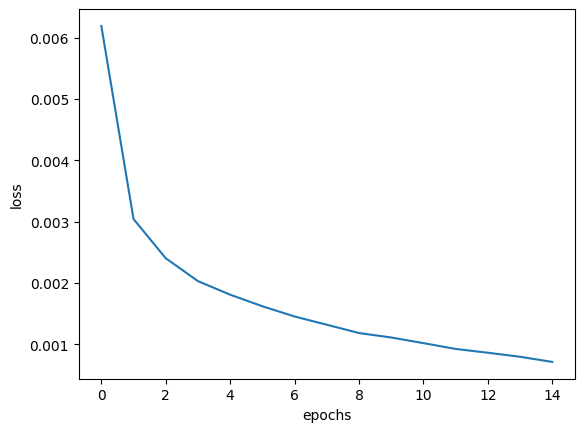

In [127]:
plt.plot(range(len(trainloss)),trainloss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [130]:
test(model,combined_testloader)

100%|██████████| 2877/2877 [00:35<00:00, 81.31it/s]

95.10123392422662
